In [ ]:
pip install gridstatusio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.9/164.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.1/931.1 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 25.2 MB/s eta 0:00:00
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4832 sha256=ffd83c609951a9c6a2fc83cdcf21896f2260e8afcb768fff63dfed2c47c06f99
  Stored in directory: /root/.cache/pip/wheels/9f/ca/d7/8f2399d70f5d641d4fef951a78d6aa4ab64cc582e1c4dec9a3
Successfully built termcolor
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.1.0
    Uninstalling termcolor-3.1.0:
      Successfully uninstalled termcolor-3.1.0
  Attempting uninstall: se

In [ ]:
%pylab inline
import pandas as pd
from gridstatusio import GridStatusClient
import os

Populating the interactive namespace from numpy and matplotlib


In [ ]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## read in API key and define key variables
from google.colab import userdata
api_key = userdata.get("GRIDSTATUS_API_KEY")

# Set start and end dates for summertime data
year = '2018'
start_date = f"{year}-06-01"
end_date = f"{year}-09-30"

In [ ]:
client  = GridStatusClient(api_key=api_key)
limit_rows = 9_000 # limit of rows for hourly data for one year
#limit_rows = 100

# 1) Hourly demand
df_load = client.get_dataset(
    "ercot_standardized_hourly",
    start=start_date,
    end=end_date,
    limit=limit_rows
)
#df_load = df_load[df_load.parameter == "Demand"]
df_load["timestamp"] = pd.to_datetime(df_load["interval_start_utc"].dt.tz_convert("US/Central"))

# 2) Hourly day‐ahead hub price
df_price = client.get_dataset(
    "ercot_spp_day_ahead_hourly",
    start=start_date,
    end=end_date,
    filter_column="location",
    filter_value="HB_HUBAVG",
    limit=limit_rows
)
df_price["timestamp"] = pd.to_datetime(df_price["interval_start_utc"]).dt.tz_convert("US/Central")

# 3) Merge on the timestamp
df = pd.merge(
    df_load[["timestamp", "load.load", "fuel_mix.solar", "fuel_mix.power_storage", "fuel_mix.wind", "net_load"]],
    df_price[["timestamp", "spp"]],
    on="timestamp",
    suffixes=("_demand", "_da_price")
)

# 4) Save or continue your analysis
df.to_csv(f"ercot_hourly_demand_and_price_{year}.csv", index = False)
print(f"Saved merged hourly demand + DA price for {year} summer.")

Fetching Page 1...Done in 0.54 seconds. 
Total rows: 2,904/9,000 (32.27% of limit)

Total number of rows: 2904
Fetching Page 1...Done in 0.51 seconds. 
Total rows: 2,904/9,000 (32.27% of limit)

Total number of rows: 2904
Saved merged hourly demand + DA price for 2018 summer.


In [ ]:
!mv ercot_hourly* "/content/drive/MyDrive/ercotData/"

In [ ]:
!ls /content/drive/MyDrive/ercotData/

ercot_hourly_demand_and_price_2015.csv	ercot_hourly_demand_and_price_2024.csv
ercot_hourly_demand_and_price_2023.csv


### read battery storage

only 2024 has summertime battery charge/discharge data.  presumably b/c there was so little storage in 2023.

In [ ]:
limit_rows = 150*288 # limit of rows for hourly data for 4 months

df_battery = client.get_dataset(
    "ercot_energy_storage_resources",
    start=start_date,
    end=end_date,
    limit=limit_rows
)
df_battery["timestamp"] = pd.to_datetime(df_battery["time_utc"]).dt.tz_convert("US/Central")
#df_battery = df_battery[["timestamp", "totalCharging", "totalDischarging", "netOutput"]]

Fetching Page 1...Done in 0.88 seconds. 
Total rows: 34,829/43,200 (80.62% of limit)

Total number of rows: 34829


In [ ]:
df_battery

,time_utc,total_charging,total_discharging,net_output,timestamp
0,2024-06-01 00:00:00+00:00,-121.912,461.572,339.661,2024-05-31 19:00:00-05:00
1,2024-06-01 00:05:00+00:00,-195.664,293.461,97.797,2024-05-31 19:05:00-05:00
2,2024-06-01 00:10:00+00:00,-111.288,180.916,69.627,2024-05-31 19:10:00-05:00
3,2024-06-01 00:15:00+00:00,-32.751,203.710,170.958,2024-05-31 19:15:00-05:00
4,2024-06-01 00:20:00+00:00,-47.858,173.270,125.412,2024-05-31 19:20:00-05:00
...,...,...,...,...,...
34824,2024-09-29 23:35:00+00:00,-73.902,2437.750,2363.847,2024-09-29 18:35:00-05:00
34825,2024-09-29 23:40:00+00:00,-58.184,2619.422,2561.238,2024-09-29 18:40:00-05:00
34826,2024-09-29 23:45:00+00:00,-157.681,2447.893,2290.212,2024-09-29 18:45:00-05:00
34827,2024-09-29 23:50:00+00:00,-281.372,2484.050,2202.678,2024-09-29 18:50:00-05:00


In [ ]:
# prompt: Using dataframe df_battery: convert timestamp to index, drop time_utc column, average the data over an hour
# Convert 'timestamp' column to datetime objects if it's not already
df_battery['timestamp'] = pd.to_datetime(df_battery['timestamp'])

# Set 'timestamp' column as the index
df_battery = df_battery.set_index('timestamp')

# Drop the 'time_utc' column
df_battery = df_battery.drop(columns=['time_utc'])

# Average the data over an hour
df_battery = df_battery.resample('H').mean()

df_battery.head()

<ipython-input-42-8e0c11ea4bdd>:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_battery = df_battery.resample('H').mean()


,total_charging,total_discharging,net_output
timestamp,,,
2024-05-31 19:00:00-05:00,-64.765250,254.316083,189.550750
2024-05-31 20:00:00-05:00,-61.557000,435.636333,374.079500
2024-05-31 21:00:00-05:00,-156.169917,198.554750,42.385167
2024-05-31 22:00:00-05:00,-296.802000,130.376417,-166.425333
2024-05-31 23:00:00-05:00,-204.772750,50.188167,-154.584667


In [ ]:
# prompt: Using dataframe df_battery: merge df_battery with df; for df_battery, using the time stored in the index, for df, use the timestamp column, drop column 'hour' from the merged df, set 'timestamp' to index
# Merge the two dataframes based on the timestamp
merged_df = pd.merge(df_battery, df, left_on='timestamp', right_on='timestamp', how='inner')

# Set the 'timestamp' column as the index
merged_df = merged_df.set_index('timestamp')
merged_df = merged_df.rename({'load.load': 'load'},axis = 1)

merged_df.to_csv(f"ercot_hourly_demand_and_price_{year}.csv")

merged_df.head()

,total_charging,total_discharging,net_output,load,spp
timestamp,,,,,
2024-05-31 19:00:00-05:00,-64.765250,254.316083,189.550750,61118.666667,57.38
2024-05-31 20:00:00-05:00,-61.557000,435.636333,374.079500,59154.000000,69.28
2024-05-31 21:00:00-05:00,-156.169917,198.554750,42.385167,57342.083333,52.55
2024-05-31 22:00:00-05:00,-296.802000,130.376417,-166.425333,54805.250000,30.50
2024-05-31 23:00:00-05:00,-204.772750,50.188167,-154.584667,51613.250000,25.45


In [ ]:
!ls -lh

total 668K
drwx------ 6 root root 4.0K May  8 15:37 drive
-rw-r--r-- 1 root root 329K May  8 20:31 ercot_hourly_demand_and_price_2023.csv
-rw-r--r-- 1 root root 328K May  8 20:32 ercot_hourly_demand_and_price_2024.csv
drwxr-xr-x 1 root root 4.0K May  6 13:38 sample_data


In [ ]:
!head ercot_hourly_demand_and_price_2023.csv

timestamp,load.load,fuel_mix.solar,fuel_mix.power_storage,fuel_mix.wind,net_load,spp
2023-05-31 19:00:00-05:00,62728.75,2868.275,258.44166666666666,18569.933333333334,41290.541666666664,27.25
2023-05-31 20:00:00-05:00,60357.0,181.98333333333332,260.825,16877.841666666664,43297.17500000001,33.08
2023-05-31 21:00:00-05:00,58227.0,0.25833333333333336,119.73333333333335,17568.958333333332,40657.78333333335,20.94
2023-05-31 22:00:00-05:00,54638.25,0.24166666666666667,29.100000000000005,19550.658333333333,35087.35,18.49
2023-05-31 23:00:00-05:00,50811.09090909091,0.27499999999999997,53.86666666666667,20462.833333333332,30383.863636363632,14.79
2023-06-01 00:00:00-05:00,47194.166666666664,0.27499999999999997,46.474999999999994,20875.05833333333,26318.833333333332,15.23
2023-06-01 01:00:00-05:00,44662.5,0.3499999999999999,45.208333333333336,19082.06666666667,25580.083333333332,12.91
2023-06-01 02:00:00-05:00,42644.416666666664,0.25,25.83333333333334,16368.891666666665,26275.274999999998,12.47


## old code

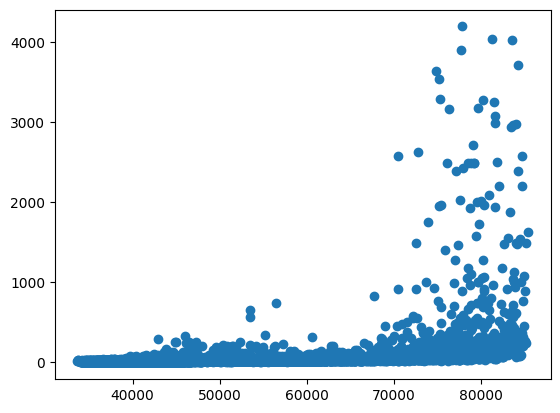

In [ ]:
plot(df['load.load'],df.spp,'o')

In [ ]:
bin_size = 2500  # 2.5 GW in MW
df['load_bin'] = pd.cut(df['load.load'], bins=range(int(df['load.load'].min()), int(df['load.load'].max()) + bin_size, bin_size))

median_price_by_load_bin = df.groupby('load_bin')['spp'].median().reset_index()
display(median_price_by_load_bin)

<ipython-input-9-467195f2e132>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_price_by_load_bin = df.groupby('load_bin')['spp'].median().reset_index()


,load_bin,spp
0,"(33664, 36164]",13.850
1,"(36164, 38664]",16.660
2,"(38664, 41164]",18.100
3,"(41164, 43664]",18.885
4,"(43664, 46164]",19.840
5,"(46164, 48664]",21.330
6,"(48664, 51164]",23.040
7,"(51164, 53664]",23.520
8,"(53664, 56164]",22.995
9,"(56164, 58664]",24.545


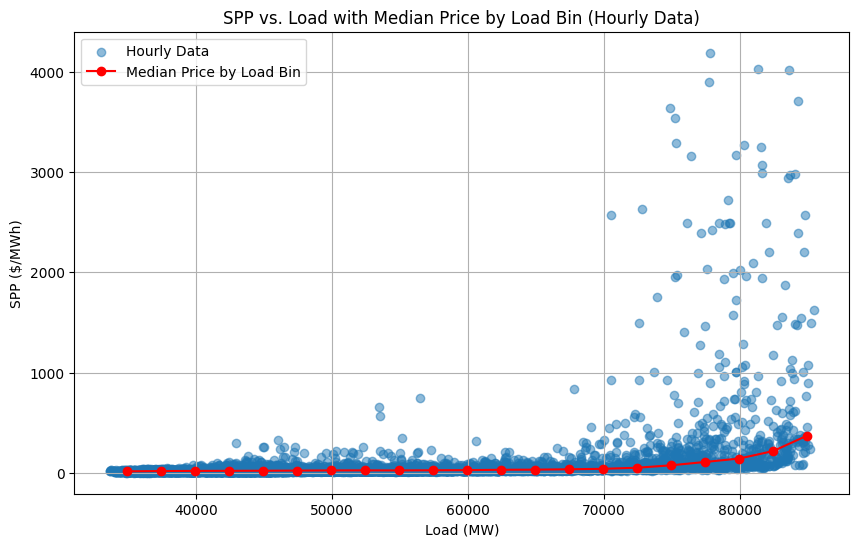

In [ ]:
import matplotlib.pyplot as plt

# Create the scatter plot of original data
plt.figure(figsize=(10, 6))
plt.scatter(df['load.load'], df['spp'], alpha=0.5, label='Hourly Data')

# Calculate the center of each bin
median_price_by_load_bin['bin_center'] = median_price_by_load_bin['load_bin'].apply(lambda x: x.mid)

# Plot the median of the bins
plt.plot(median_price_by_load_bin['bin_center'], median_price_by_load_bin['spp'], color='red', marker='o', linestyle='-', label='Median Price by Load Bin')

plt.xlabel('Load (MW)')
plt.ylabel('SPP ($/MWh)')
plt.title('SPP vs. Load with Median Price by Load Bin (Hourly Data)')
plt.legend()
plt.grid(True)
# plt.ylim(0,200) # Removed y-axis limit
plt.show()

# Task
Analyze the relationship between daily average load and daily average electricity price by binning the daily average load into 2.5 GW intervals and calculating the median daily average price within each bin. Visualize this relationship with a scatter plot of daily average load vs. daily average price, overlaid with the median price for each load bin.

## Calculate daily averages

### Subtask:
Group the DataFrame by day and calculate the average 'load.load' and 'spp' for each day.


**Reasoning**:
Convert the 'timestamp' column to datetime objects, set it as the index, resample to daily frequency calculating the mean, and then reset the index to create the `df_daily` DataFrame as requested by the instructions.



In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df_daily = df.resample('D')[['load.load', 'spp']].mean().reset_index()
display(df_daily.head())

,timestamp,load.load,spp
0,2023-01-01 00:00:00+00:00,37436.440972,14.462083
1,2023-01-02 00:00:00+00:00,39547.128472,13.698333
2,2023-01-03 00:00:00+00:00,40617.756944,16.242500
3,2023-01-04 00:00:00+00:00,40756.072917,21.040000
4,2023-01-05 00:00:00+00:00,42093.920139,32.522083


## Bin daily average load and calculate median price by load bin

### Subtask:
Bin the daily average 'load.load' data into 2.5 GW bins and calculate the median of the daily average 'spp' for each bin.

**Reasoning**:
Bin the 'load.load' column in the `df_daily` DataFrame using `pd.cut` with a bin size of 2500 MW (2.5 GW). Then, group the `df_daily` DataFrame by these new load bins and calculate the median of the 'spp' column for each group, resetting the index to create `median_price_by_daily_load_bin`.

In [ ]:
bin_size = 2500  # 2.5 GW in MW
df_daily['load_bin'] = pd.cut(df_daily['load.load'], bins=range(int(df_daily['load.load'].min()), int(df_daily['load.load'].max()) + bin_size, bin_size))

median_price_by_daily_load_bin = df_daily.groupby('load_bin')['spp'].median().reset_index()
display(median_price_by_daily_load_bin)

<ipython-input-13-237afca94b24>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_price_by_daily_load_bin = df_daily.groupby('load_bin')['spp'].median().reset_index()


,load_bin,spp
0,"(37436, 39936]",21.574167
1,"(39936, 42436]",21.507083
2,"(42436, 44936]",21.747083
3,"(44936, 47436]",24.042500
4,"(47436, 49936]",26.971667
5,"(49936, 52436]",28.927917
6,"(52436, 54936]",30.977917
7,"(54936, 57436]",31.886667
8,"(57436, 59936]",33.282292
9,"(59936, 62436]",49.794167


## Plot daily data and median bins

### Subtask:
Create a scatter plot of the daily average 'load.load' vs. daily average 'spp', and overlay the median daily average 'spp' for each bin using the bin centers.

**Reasoning**:
Create a scatter plot of the daily averaged data (`df_daily`) using `matplotlib.pyplot`. Calculate the center of each bin in `median_price_by_daily_load_bin` and then plot these median values against the bin centers on the same axes. Add labels, a title, a legend, and a grid to the plot for clarity. Finally, display the plot.

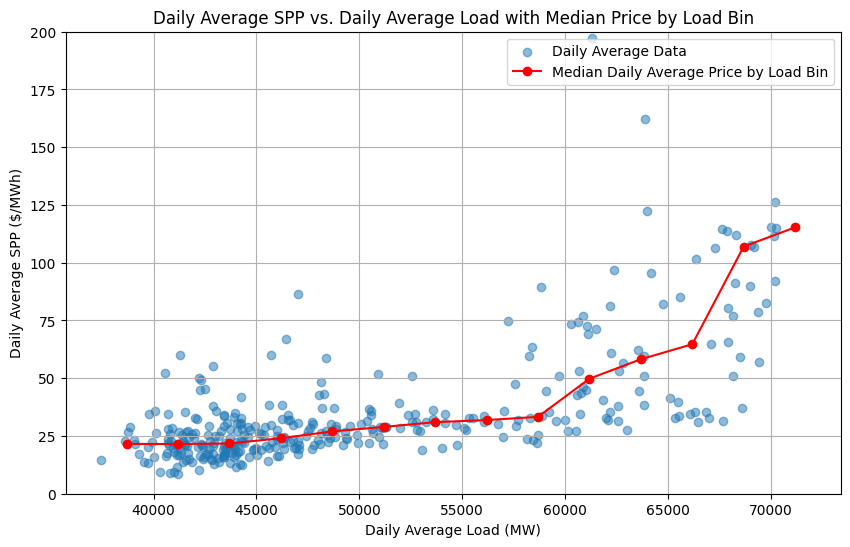

In [ ]:
import matplotlib.pyplot as plt

# Create the scatter plot of daily data
plt.figure(figsize=(10, 6))
plt.scatter(df_daily['load.load'], df_daily['spp'], alpha=0.5, label='Daily Average Data')

# Calculate the center of each bin
median_price_by_daily_load_bin['bin_center'] = median_price_by_daily_load_bin['load_bin'].apply(lambda x: x.mid)

# Plot the median of the bins
plt.plot(median_price_by_daily_load_bin['bin_center'], median_price_by_daily_load_bin['spp'], color='red', marker='o', linestyle='-', label='Median Daily Average Price by Load Bin')

plt.xlabel('Daily Average Load (MW)')
plt.ylabel('Daily Average SPP ($/MWh)')
plt.title('Daily Average SPP vs. Daily Average Load with Median Price by Load Bin')
plt.legend()
plt.grid(True)
plt.ylim(0,200)
plt.show()

# Task
Plot the median daily average SPP price vs. daily average load for 2.5 GW load bins for both 2023 and 2024 on the same plot.

## Fetch 2024 data

### Subtask:
Fetch the hourly demand and day-ahead hub price data for the year 2024 using the `GridStatusClient`.


**Reasoning**:
Fetch the hourly demand data for 2024, convert the timestamp column to datetime objects, fetch the hourly day-ahead price data for 2024 with the specified filter and limit, and convert the timestamp column to datetime objects.



In [ ]:
df_load_2024 = client.get_dataset(
    "ercot_standardized_hourly",
    start="2024-01-01",
    end="2024-12-31",
    limit=10_000
)
df_load_2024["timestamp"] = pd.to_datetime(df_load_2024["interval_start_utc"])

df_price_2024 = client.get_dataset(
    "ercot_spp_day_ahead_hourly",
    start="2024-01-01",
    end="2024-12-31",
    filter_column="location",
    filter_value="HB_HUBAVG",
    limit=10_000
)
df_price_2024["timestamp"] = pd.to_datetime(df_price_2024["interval_start_utc"])

display(df_load_2024.head())
display(df_price_2024.head())

Fetching Page 1...Done in 1.75 seconds. 
Total rows: 8,760/10,000 (87.6% of limit)

Total number of rows: 8760
Fetching Page 1...Done in 6.38 seconds. 
Total rows: 8,760/10,000 (87.6% of limit)

Total number of rows: 8760


,interval_start_utc,interval_end_utc,load_forecast.load_forecast,net_load,renewables,renewables_to_load_ratio,load.load,fuel_mix.coal_and_lignite,fuel_mix.hydro,fuel_mix.nuclear,fuel_mix.power_storage,fuel_mix.solar,fuel_mix.wind,fuel_mix.natural_gas,fuel_mix.other,timestamp
0,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00,46125.268557,31689.133333,14175.225000,0.309187,45846.833333,8482.441667,17.525000,5115.283333,153.433333,0.008333,14157.691667,17880.208333,0.0,2024-01-01 00:00:00+00:00
1,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00,45992.678012,27740.808333,17132.433333,0.382137,44833.166667,6550.533333,40.075000,5115.983333,163.058333,0.000000,17092.358333,15982.558333,0.0,2024-01-01 01:00:00+00:00
2,2024-01-01 02:00:00+00:00,2024-01-01 03:00:00+00:00,44949.177376,25734.525000,18271.500000,0.415372,43988.333333,6009.725000,17.691667,5114.975000,142.883333,0.625000,18253.183333,14492.958333,0.0,2024-01-01 02:00:00+00:00
3,2024-01-01 03:00:00+00:00,2024-01-01 04:00:00+00:00,43898.730268,24646.433333,18611.983333,0.430251,43258.416667,5993.366667,0.000000,5115.141667,91.725000,0.058333,18611.925000,13505.441667,0.0,2024-01-01 03:00:00+00:00
4,2024-01-01 04:00:00+00:00,2024-01-01 05:00:00+00:00,42819.666039,24345.233333,17934.850000,0.424191,42280.083333,5997.608333,0.000000,5114.866667,86.525000,0.000000,17934.850000,13286.433333,0.0,2024-01-01 04:00:00+00:00


,interval_start_utc,interval_end_utc,location,location_type,market,spp,timestamp
0,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00,HB_HUBAVG,Trading Hub,DAY_AHEAD_HOURLY,24.84,2024-01-01 00:00:00+00:00
1,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00,HB_HUBAVG,Trading Hub,DAY_AHEAD_HOURLY,20.64,2024-01-01 01:00:00+00:00
2,2024-01-01 02:00:00+00:00,2024-01-01 03:00:00+00:00,HB_HUBAVG,Trading Hub,DAY_AHEAD_HOURLY,17.51,2024-01-01 02:00:00+00:00
3,2024-01-01 03:00:00+00:00,2024-01-01 04:00:00+00:00,HB_HUBAVG,Trading Hub,DAY_AHEAD_HOURLY,15.09,2024-01-01 03:00:00+00:00
4,2024-01-01 04:00:00+00:00,2024-01-01 05:00:00+00:00,HB_HUBAVG,Trading Hub,DAY_AHEAD_HOURLY,16.13,2024-01-01 04:00:00+00:00


## Merge 2024 data

### Subtask:
Merge the 2024 hourly demand and price data on the timestamp.

**Reasoning**:
Merge the `df_load_2024` and `df_price_2024` DataFrames using an inner merge on the 'timestamp' column to create the `df_2024` DataFrame containing both 'load.load' and 'spp' for 2024. Display the head of the merged DataFrame to verify the merge was successful.

In [ ]:
df_2024 = pd.merge(
    df_load_2024[["timestamp", "load.load"]],
    df_price_2024[["timestamp", "spp"]],
    on="timestamp",
    suffixes=("_demand", "_da_price")
)
display(df_2024.head())

,timestamp,load.load,spp
0,2024-01-01 00:00:00+00:00,45846.833333,24.84
1,2024-01-01 01:00:00+00:00,44833.166667,20.64
2,2024-01-01 02:00:00+00:00,43988.333333,17.51
3,2024-01-01 03:00:00+00:00,43258.416667,15.09
4,2024-01-01 04:00:00+00:00,42280.083333,16.13


## Calculate Daily Averages for 2024

### Subtask:
Group the merged 2024 DataFrame by day and calculate the average 'load.load' and 'spp' for each day.

**Reasoning**:
Convert the 'timestamp' column of the `df_2024` DataFrame to datetime objects, set it as the index, resample to daily frequency calculating the mean, and then reset the index to create the `df_daily_2024` DataFrame. Display the head of the resulting DataFrame to verify the daily averages are calculated correctly.

In [ ]:
df_2024['timestamp'] = pd.to_datetime(df_2024['timestamp'])
df_2024 = df_2024.set_index('timestamp')
df_daily_2024 = df_2024.resample('D')[['load.load', 'spp']].mean().reset_index()
display(df_daily_2024.head())

,timestamp,load.load,spp
0,2024-01-01 00:00:00+00:00,44121.659722,19.748750
1,2024-01-02 00:00:00+00:00,50075.333333,25.352500
2,2024-01-03 00:00:00+00:00,49117.190972,27.027917
3,2024-01-04 00:00:00+00:00,48930.590278,20.119167
4,2024-01-05 00:00:00+00:00,46973.381944,18.600417


## Bin Daily Average Load for 2024

### Subtask:
Bin the 2024 daily average 'load.load' data into 2.5 GW bins.

**Reasoning**:
Bin the 'load.load' column in the `df_daily_2024` DataFrame using `pd.cut` with a bin size of 2500 MW (2.5 GW). Store the results in a new column called 'load_bin'.

In [ ]:
bin_size = 2500  # 2.5 GW in MW
df_daily_2024['load_bin'] = pd.cut(df_daily_2024['load.load'], bins=range(int(df_daily_2024['load.load'].min()), int(df_daily_2024['load.load'].max()) + bin_size, bin_size))
display(df_daily_2024.head())

,timestamp,load.load,spp,load_bin
0,2024-01-01 00:00:00+00:00,44121.659722,19.748750,"(43615, 46115]"
1,2024-01-02 00:00:00+00:00,50075.333333,25.352500,"(48615, 51115]"
2,2024-01-03 00:00:00+00:00,49117.190972,27.027917,"(48615, 51115]"
3,2024-01-04 00:00:00+00:00,48930.590278,20.119167,"(48615, 51115]"
4,2024-01-05 00:00:00+00:00,46973.381944,18.600417,"(46115, 48615]"


## Calculate Median Daily Price by Load Bin for 2024

### Subtask:
Group the 2024 daily averaged data by the new load bins and calculate the median of the daily average 'spp' for each bin.

**Reasoning**:
Group the `df_daily_2024` DataFrame by the 'load_bin' column and calculate the median of the 'spp' column for each group. Reset the index to create the `median_price_by_daily_load_bin_2024` DataFrame. Display the resulting DataFrame to inspect the median prices for each bin.

In [ ]:
median_price_by_daily_load_bin_2024 = df_daily_2024.groupby('load_bin')['spp'].median().reset_index()
display(median_price_by_daily_load_bin_2024)

<ipython-input-19-8504daea393a>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_price_by_daily_load_bin_2024 = df_daily_2024.groupby('load_bin')['spp'].median().reset_index()


,load_bin,spp
0,"(41115, 43615]",16.484167
1,"(43615, 46115]",19.085000
2,"(46115, 48615]",22.025417
3,"(48615, 51115]",24.049167
4,"(51115, 53615]",24.422083
5,"(53615, 56115]",24.253958
6,"(56115, 58615]",24.885000
7,"(58615, 61115]",25.925417
8,"(61115, 63615]",26.956250
9,"(63615, 66115]",26.789583


## Calculate Bin Centers for 2024

### Subtask:
Calculate the center of each load bin for the 2024 median data.

**Reasoning**:
Apply a lambda function to the 'load_bin' column of the `median_price_by_daily_load_bin_2024` DataFrame to calculate the midpoint of each interval and store the results in a new column called 'bin_center'. Display the head of the updated DataFrame to verify the bin centers are calculated correctly.

In [ ]:
median_price_by_daily_load_bin_2024['bin_center'] = median_price_by_daily_load_bin_2024['load_bin'].apply(lambda x: x.mid)
display(median_price_by_daily_load_bin_2024.head())

,load_bin,spp,bin_center
0,"(41115, 43615]",16.484167,42365.0
1,"(43615, 46115]",19.085000,44865.0
2,"(46115, 48615]",22.025417,47365.0
3,"(48615, 51115]",24.049167,49865.0
4,"(51115, 53615]",24.422083,52365.0


## Plot Median Bins for 2023 and 2024

### Subtask:
Create a plot that shows the median daily average 'spp' for each load bin for both 2023 and 2024 on the same axes.

**Reasoning**:
Create a scatter plot using `matplotlib.pyplot`. Plot the 'bin_center' and 'spp' from `median_price_by_daily_load_bin` (for 2023) and `median_price_by_daily_load_bin_2024` (for 2024) on the same axes with different colors and labels. Add appropriate labels for the x and y axes, a title for the plot, a legend to distinguish the two years, and a grid for readability. Set the y-axis limit to 200 for better visualization of the lower price ranges. Finally, display the plot.

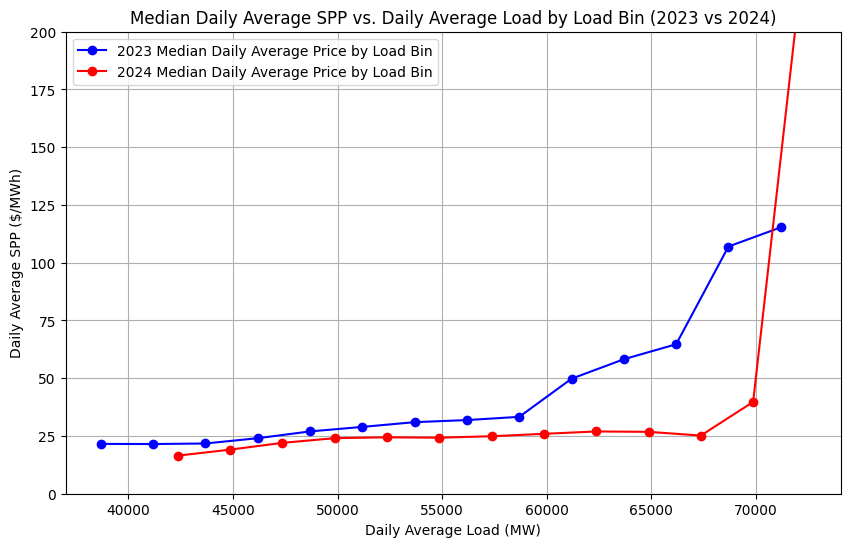

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot median price by load bin for 2023
plt.plot(median_price_by_daily_load_bin['bin_center'], median_price_by_daily_load_bin['spp'], color='blue', marker='o', linestyle='-', label='2023 Median Daily Average Price by Load Bin')

# Plot median price by load bin for 2024
plt.plot(median_price_by_daily_load_bin_2024['bin_center'], median_price_by_daily_load_bin_2024['spp'], color='red', marker='o', linestyle='-', label='2024 Median Daily Average Price by Load Bin')

plt.xlabel('Daily Average Load (MW)')
plt.ylabel('Daily Average SPP ($/MWh)')
plt.title('Median Daily Average SPP vs. Daily Average Load by Load Bin (2023 vs 2024)')
plt.legend()
plt.grid(True)
plt.ylim(0, 200)
plt.show()

# Task
Plot the median hourly price vs. binned hourly load for 2023 and 2024 on the same plot.

## Bin hourly load for 2024

### Subtask:
Bin the 2024 hourly 'load.load' data into 2.5 GW bins.


**Reasoning**:
Define the bin size, then bin the 'load.load' column of `df_2024` into the specified bins and add the results as a new column 'load_bin'. Finally, display the head of the dataframe to show the new column.



In [ ]:
bin_size = 2500  # 2.5 GW in MW
df_2024['load_bin'] = pd.cut(df_2024['load.load'], bins=range(int(df_2024['load.load'].min()), int(df_2024['load.load'].max()) + bin_size, bin_size))
display(df_2024.head())

,load.load,spp,load_bin
timestamp,,,
2024-01-01 00:00:00+00:00,45846.833333,24.84,"(43698, 46198]"
2024-01-01 01:00:00+00:00,44833.166667,20.64,"(43698, 46198]"
2024-01-01 02:00:00+00:00,43988.333333,17.51,"(43698, 46198]"
2024-01-01 03:00:00+00:00,43258.416667,15.09,"(41198, 43698]"
2024-01-01 04:00:00+00:00,42280.083333,16.13,"(41198, 43698]"


## Calculate Median Hourly Price by Load Bin for 2024

### Subtask:
Group the 2024 hourly data by the new load bins and calculate the median of the hourly 'spp' for each bin.

**Reasoning**:
Group the `df_2024` DataFrame by the 'load_bin' column and calculate the median of the 'spp' column for each group. Reset the index to create the `median_price_by_hourly_load_bin_2024` DataFrame. Display the resulting DataFrame to inspect the median prices for each bin.

In [ ]:
median_price_by_hourly_load_bin_2024 = df_2024.groupby('load_bin')['spp'].median().reset_index()
display(median_price_by_hourly_load_bin_2024)

<ipython-input-24-11dec685922c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_price_by_hourly_load_bin_2024 = df_2024.groupby('load_bin')['spp'].median().reset_index()


,load_bin,spp
0,"(36198, 38698]",10.850
1,"(38698, 41198]",14.890
2,"(41198, 43698]",15.315
3,"(43698, 46198]",16.380
4,"(46198, 48698]",18.160
5,"(48698, 51198]",19.140
6,"(51198, 53698]",19.120
7,"(53698, 56198]",18.350
8,"(56198, 58698]",18.760
9,"(58698, 61198]",21.230


## Calculate Bin Centers for 2024 Hourly Data

### Subtask:
Calculate the center of each load bin for the 2024 median hourly data.

**Reasoning**:
Apply a lambda function to the 'load_bin' column of the `median_price_by_hourly_load_bin_2024` DataFrame to calculate the midpoint of each interval and store the results in a new column called 'bin_center'. Display the head of the updated DataFrame to verify the bin centers are calculated correctly.

In [ ]:
median_price_by_hourly_load_bin_2024['bin_center'] = median_price_by_hourly_load_bin_2024['load_bin'].apply(lambda x: x.mid)
display(median_price_by_hourly_load_bin_2024.head())

,load_bin,spp,bin_center
0,"(36198, 38698]",10.850,37448.0
1,"(38698, 41198]",14.890,39948.0
2,"(41198, 43698]",15.315,42448.0
3,"(43698, 46198]",16.380,44948.0
4,"(46198, 48698]",18.160,47448.0


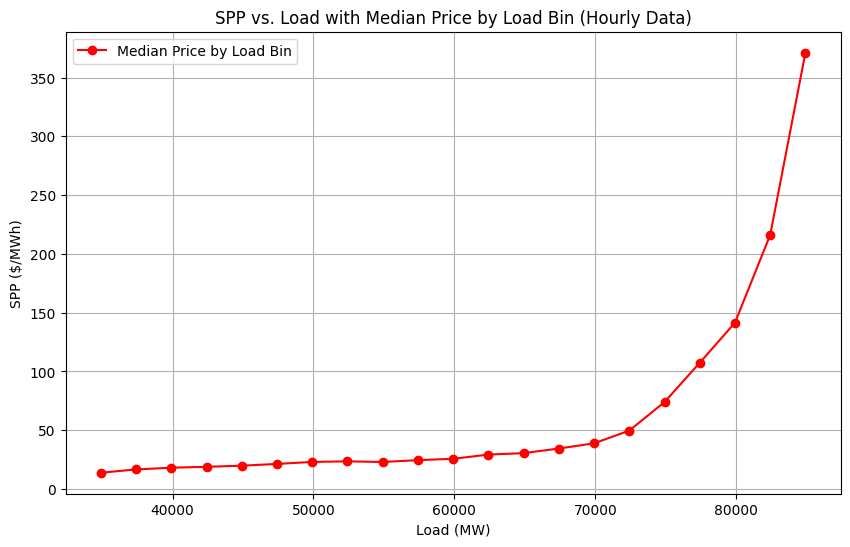

In [ ]:
# Create the scatter plot of original data
plt.figure(figsize=(10, 6))
#plt.scatter(df['load.load'], df['spp'], alpha=0.5, label='Hourly Data')

# Calculate the center of each bin
median_price_by_load_bin['bin_center'] = median_price_by_load_bin['load_bin'].apply(lambda x: x.mid)

# Plot the median of the bins
plt.plot(median_price_by_load_bin['bin_center'], median_price_by_load_bin['spp'], color='red', marker='o', linestyle='-', label='Median Price by Load Bin')

plt.xlabel('Load (MW)')
plt.ylabel('SPP ($/MWh)')
plt.title('SPP vs. Load with Median Price by Load Bin (Hourly Data)')
plt.legend()
plt.grid(True)
# plt.ylim(0,200) # Removed y-axis limit
plt.show()

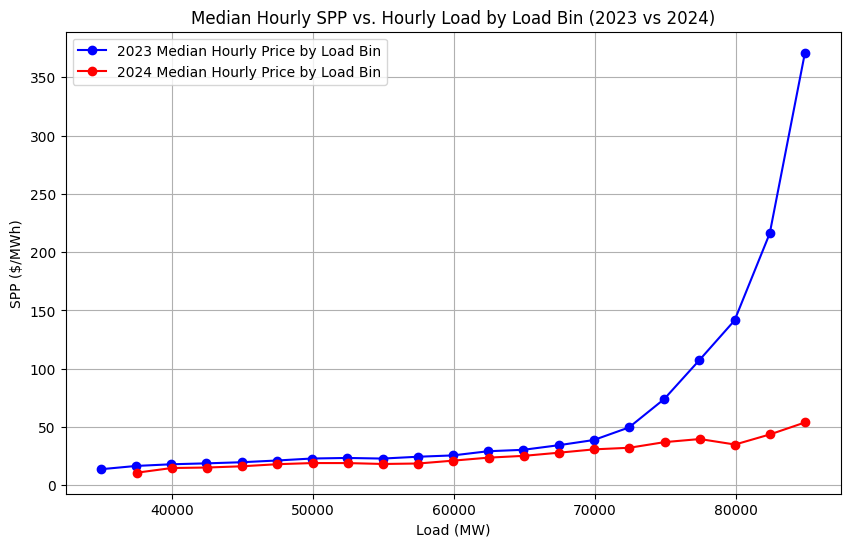

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the median of the bins for 2023 hourly data
plt.plot(median_price_by_load_bin['bin_center'], median_price_by_load_bin['spp'], color='blue', marker='o', linestyle='-', label='2023 Median Hourly Price by Load Bin')

# Plot the median of the bins for 2024 hourly data
plt.plot(median_price_by_hourly_load_bin_2024['bin_center'], median_price_by_hourly_load_bin_2024['spp'], color='red', marker='o', linestyle='-', label='2024 Median Hourly Price by Load Bin')


plt.xlabel('Load (MW)')
plt.ylabel('SPP ($/MWh)')
plt.title('Median Hourly SPP vs. Hourly Load by Load Bin (2023 vs 2024)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import pandas as pd
from gridstatusio import GridStatusClient

client  = GridStatusClient(api_key=api_key)

# 1) Hourly demand
df_load = client.get_dataset(
    "ercot_standardized_hourly",
    start="2023-01-01",
    end="2023-12-31",
    limit=10_000
)
#df_load = df_load[df_load.parameter == "Demand"]
df_load["timestamp"] = pd.to_datetime(df_load["interval_start_utc"])

# 2) Hourly day‐ahead hub price
df_price = client.get_dataset(
    "ercot_spp_day_ahead_hourly",
    start="2023-01-01",
    end="2023-12-31",
    filter_column="location",
    filter_value="HB_HUBAVG",
    limit=10_000
)
df_price["timestamp"] = pd.to_datetime(df_price["interval_start_utc"])

# 3) Merge on the timestamp
df = pd.merge(
    df_load[["timestamp", "load.load"]],
    df_price[["timestamp", "spp"]],
    on="timestamp",
    suffixes=("_demand", "_da_price")
)

# Filter for summertime data (June 1 to Sept 30)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_summer = df[(df['timestamp'].dt.month >= 6) & (df['timestamp'].dt.month <= 9)].copy()


# 4) Save or continue your analysis
#df.to_csv("ercot_hourly_demand_and_da_price.csv", index=False)
print("Saved merged hourly demand + DA price for 2023–24.")

Fetching Page 1...Done in 1.78 seconds. 
Total rows: 8,736/10,000 (87.36% of limit)

Total number of rows: 8736
Fetching Page 1...Done in 3.86 seconds. 
Total rows: 8,736/10,000 (87.36% of limit)

Total number of rows: 8736
Saved merged hourly demand + DA price for 2023–24.
